In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import folium
import numpy as np


plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
from IPython.display import display

In [2]:
df = pd.read_csv('data/df_mile.csv')
df.head()

,time,latitude,longitude,elevation,pointxyz,euc_dist,distance,euc_mph,elevation_change,cum_elevation,cum_distance,5sec_rolling_elv,second,elapsed_time,step_feet,moving_time,mile_num,grade_section
0,2021-11-19 14:52:53+00:00,38.796494,-77.045523,-3.0,"(38.79649353213608, -77.04552322626114, -3.0)",0.000000,0.000000,0.000000,0.0,0.0,0.000000,NaN,0,0:00:00,0.000000,0,1.0,1.0
1,2021-11-19 14:52:54+00:00,38.796489,-77.045519,-3.0,"(38.79648883827031, -77.04551886767149, -3.0)",0.000400,0.000400,1.440858,0.0,0.0,0.000400,NaN,1,0:00:01,2.113258,1,1.0,1.0
2,2021-11-19 14:52:55+00:00,38.796473,-77.045510,-3.0,"(38.796473080292344, -77.04550998285413, -3.0)",0.001188,0.001189,4.277103,0.0,0.0,0.001590,NaN,2,0:00:02,6.273084,1,1.0,1.0
3,2021-11-19 14:52:56+00:00,38.796457,-77.045503,-3.0,"(38.79645690321922, -77.04550285823643, -3.0)",0.001180,0.001182,4.249086,0.0,0.0,0.002771,NaN,3,0:00:03,6.231993,1,1.0,1.0
4,2021-11-19 14:52:57+00:00,38.796427,-77.045499,-2.8,"(38.796427231281996, -77.04549883492291, -2.79...",0.002062,0.002062,7.422258,0.2,0.2,0.004833,0.04,4,0:00:04,10.885979,1,1.0,1.0


In [69]:
testEldiff = np.round(df['elevation_change'][4],2)
distM = np.round(df['distance'][4]/0.62137119*1000,2)

testEl = 1.86
testDist= 87.59
print('test',testEl/testDist*100)

print("Elevation change in meters", testEldiff)

print('Distance in M ',distM)
print('Gradient  ',df['elevation_change'][4] / (df['distance'][4]/0.62137119*1000)*100)





test 2.1235300833428474
Elevation change in meters 0.2
Distance in M  3.32
Gradient   6.028195660027029


# each data point gradient calc

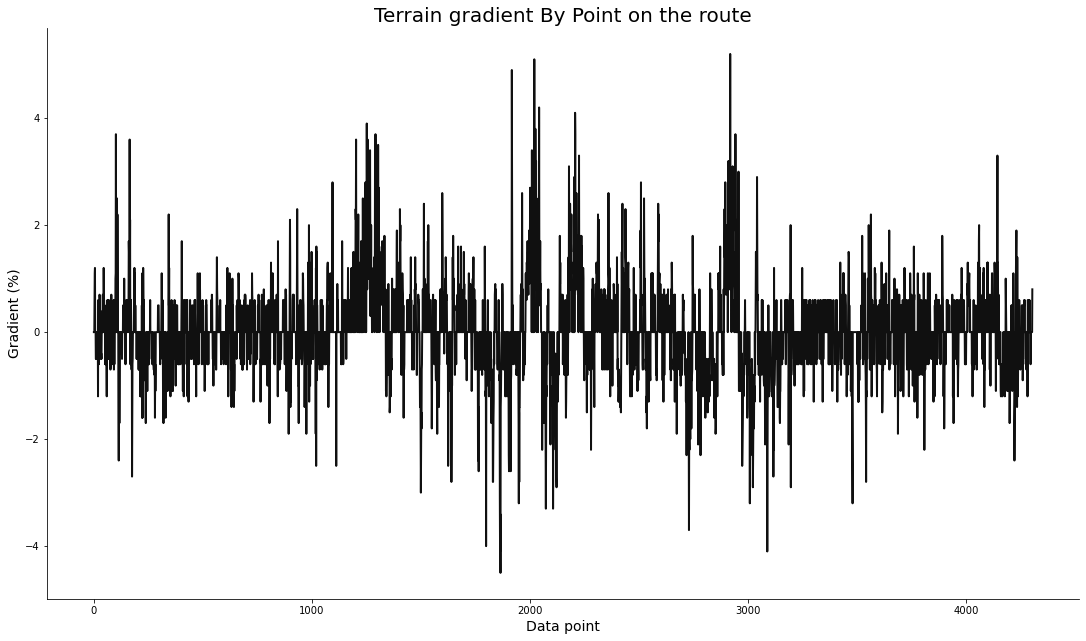

In [71]:
# gradient just from each step

conversion_factor = 0.62137119
gradient_each_point =[np.nan]
for ind, row in df.iterrows():
    if ind == 0:
        continue
    grade = (row['elevation_change'] / (row['distance']/conversion_factor*100))
    if row['moving_time'] == 0 :
        gradient_each_point.append(0)
    # if grade > cap_high :
    #     gradient_each_point.append(0)
    else:
        gradient_each_point.append(np.round(grade,1))
    

plt.figure(figsize=(18.5, 10.5))
plt.title('Terrain gradient By Point on the route', size=20)
plt.xlabel('Data point', size=14)
plt.ylabel('Gradient (%)', size=14)
plt.plot(np.arange(len(gradient_each_point)), gradient_each_point, lw=2, color='#101010');

In [78]:
df['gradient_each_point'] = gradient_each_point

df['euc_mph'].describe()

count    4304.000000
mean        7.050208
std         1.809371
min         0.000000
25%         6.073177
50%         7.324486
75%         8.077030
max        36.270216
Name: euc_mph, dtype: float64

In [79]:
prev = df['second'][0]
conversion_factor = 0.62137119
grade_section_speed =[]
grade_pace =[]
mile_marker = []

for i in range(len(df)):
    
    unit_speed = df['euc_mph'][i]
    if unit_speed == 0:
        unit_pace = 0
    else:
        unit_pace = str(datetime.timedelta(seconds=60/unit_speed*60))
    grade_section_speed.append(np.round(unit_speed,2))
    grade_pace.append(unit_pace)
    mile_marker.append(df['mile_num'][i])
    
    

In [84]:
len(mile_marker)

4304

In [85]:
d={'mile_number':mile_marker,'speed_mph':grade_section_speed,'pace':grade_pace,'gradient':gradient_each_point}
speed_grade = pd.DataFrame(data = d)
speed_grade.describe()

,mile_number,speed_mph,gradient
count,4304.000000,4304.000000,4303.000000
mean,4.725139,7.050260,0.023495
std,2.335742,1.809376,0.834684
min,1.000000,0.000000,-4.500000
25%,3.000000,6.070000,-0.500000
50%,5.000000,7.325000,0.000000
75%,7.000000,8.080000,0.500000
max,9.000000,36.270000,5.200000


In [86]:
import altair as alt

selection = alt.selection_multi(fields=['mile_number'])


scatter = alt.Chart(speed_grade).mark_point(size=50).encode(
    alt.X("gradient"),
    alt.Y("speed_mph"),
    alt.Color("mile_number",
                legend = alt.Legend(
                    title = "Mile Number",
                    orient = 'left',
                    titleFontSize=15,
                    labelFontSize=13)
                ),
    opacity = alt.condition(selection, alt.value(1),alt.value(0))
).properties(
    height=350, width=500
).configure_axis(
    titleFontSize=20,
    labelFontSize=15
).add_selection(
    selection
)

scatter


alt.Chart(...)

In [87]:
source = speed_grade

brush = alt.selection(type='interval')

points = alt.Chart(source).mark_point().encode(
    x='gradient:N',
    y='speed_mph:Q',
    color=alt.condition(brush, 'mile_number:N', alt.value('lightgray'))
).properties(
    height=350, width=800
).add_selection(
    brush
)

bars = alt.Chart(source).mark_bar().encode(
    y='mile_number:N',
    color='mile_number:N',
    x='count(mile_number):Q'
).transform_filter(
    brush
)

points & bars

alt.VConcatChart(...)

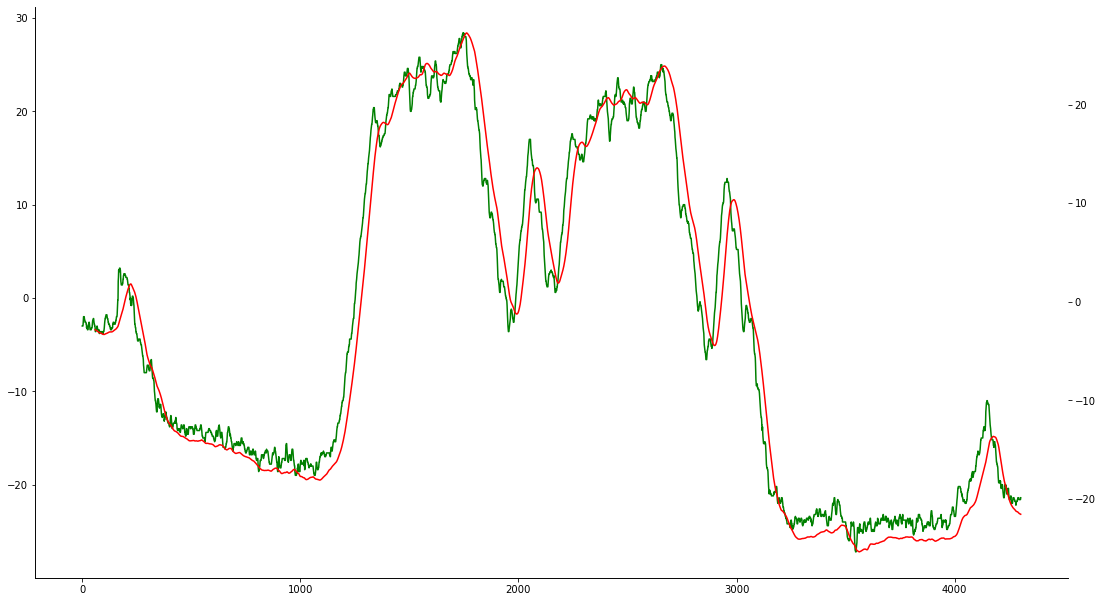

In [14]:
# Experiment with mean max and min on rolling elevation change
elv_period = 120
fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax2 = ax1.twinx()
ax1.plot(df.index,df['elevation'], c='g')
ax2.plot(df.index,df['elevation'].rolling(60).mean(), c='r')
# ax2.plot(df.index[0:2000],df['elevation_change'].rolling(elv_period).max()[0:2000], c='r')
# ax2.plot(df.index[0:2000],df['elevation_change'].rolling(elv_period).min()[0:2000], c='b')